<a href="https://colab.research.google.com/github/urvog/NLP-Sentiment-Analysis/blob/main/NLP_Multiclass_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [240]:
import pandas as pd
import numpy as np
import re, string, spacy
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

pd.options.display.max_colwidth = None
np.random.seed(123)

# Importando los datos

In [241]:
!ls data/

df_anger.csv               df_pessimism.csv
df_anticipation.csv        df_sadness.csv
df_disgust.csv             df_surprise.csv
df_fear.csv                df_trust.csv
df_joy.csv                 sem_eval_test_blank_es.csv
df_love.csv                sem_eval_train_es.csv
df_optimism.csv


In [242]:
# Leemos los datos
SENTIMENT_NAME = "pessimism" #esta variable de sentimiento tiene que ser cambiado por los otros 10 sentimientos disponibles en el Dataset
                         #Ejecutamos 11 veces todo el codigo que generara los csv resultantes por cada sentimiento.
df = pd.read_csv('data/df_'+SENTIMENT_NAME+'.csv', index_col=None)
df.columns = ['Tweet','Sentiment']
df[df.Sentiment>0]

,Tweet,Sentiment
1,@AwadaNai la mala suerte del gato fichame la cara de help me pls,1
5,"En Venezuela, el tráfico aéreo esta tan peligroso como el terrestre? Ya cayó otra avioneta.",1
9,"Con razon mi vieja se fue rapido a Santa Fe sin invitarme, no queria que me tatue denuevo",1
13,@LastiriAriel una pintura para mañana creo q tuve q haberme preocupado un poquito antes🤦🏻,1
20,"""-te ves como de 25 -sí, ya se -¿qué te dieron de chiquita para verte tan grande?"" Wey, ya se que tengo cuerpo de treintona y soy amargada",1
...,...,...
3523,"No me puedo dormir bo, si alguien me habla no me enojo",1
3536,"@pcayuqueo He visto demonios vistiendo santos, pero estos tipos por lejos los más cínicos 😒😒",1
3549,me siento super miserable ahorita porque soy una seria amargada de mierda pero tengo comida :),1
3552,"""Hombres cuya única preocupación pasa por si sus nalgas estan erguidas""",1


# Limpiando los datos


In [243]:
#!python -m spacy download es_core_news_md
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

# Preparando los Datos

In [244]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.Tweet=df.Tweet.apply(clean_text, lemas=True)
df = df[df['Tweet']!='']

#Enviamos a Y los codigos asignados por label encodr, hay que convertir a numérico para Keras
Y=df.Sentiment

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.Tweet,Y, test_size = 0.3, random_state = 42)

In [245]:
#Tokenizamos los textos
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(tweets_train.values)

X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Número de tokens distintos: {len(word_index)}')
MAX_SEQUENCE_LENGTH = X_train.shape[1]
max_features = len(word_index)+1
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Número de tokens distintos: 5769


In [246]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2492, 33) (2492,)
(1069, 33) (1069,)


# Preparamos el Modelo

In [247]:
#Creamos el modelo CNN en Keras
#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
          
# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

# conectamos a una capa de salida de una unidad con activación relu
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 33, 50)            288500    
                                                                 
 dropout_23 (Dropout)        (None, 33, 50)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 31, 64)            9664      
                                                                 
 global_max_pooling1d_17 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
 activation_17 (Activation)  (None, 1)                 0         
                                                     

# Entrenamiento

In [248]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20


2022-07-09 22:52:20.763344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 22:52:23.947154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 - 4s - loss: 0.4708 - accuracy: 0.8291 - val_loss: 0.4540 - val_accuracy: 0.8316 - 4s/epoch - 25ms/step
Epoch 2/20
156/156 - 2s - loss: 0.4246 - accuracy: 0.8403 - val_loss: 0.4364 - val_accuracy: 0.8335 - 2s/epoch - 10ms/step
Epoch 3/20
156/156 - 1s - loss: 0.3558 - accuracy: 0.8507 - val_loss: 0.4234 - val_accuracy: 0.8344 - 1s/epoch - 9ms/step
Epoch 4/20
156/156 - 1s - loss: 0.2342 - accuracy: 0.9009 - val_loss: 0.4638 - val_accuracy: 0.8138 - 1s/epoch - 8ms/step
Epoch 5/20
156/156 - 1s - loss: 0.1281 - accuracy: 0.9567 - val_loss: 0.5319 - val_accuracy: 0.8073 - 1s/epoch - 9ms/step
Epoch 6/20
156/156 - 1s - loss: 0.0681 - accuracy: 0.9795 - val_loss: 0.6338 - val_accuracy: 0.8148 - 1s/epoch - 8ms/step
Epoch 7/20
156/156 - 1s - loss: 0.0405 - accuracy: 0.9892 - val_loss: 0.6781 - val_accuracy: 0.8064 - 1s/epoch - 9ms/step
Epoch 8/20
156/156 - 1s - loss: 0.0251 - accuracy: 0.9940 - val_loss: 0.7568 - val_accuracy: 0.8148 - 1s/epoch - 8ms/step
Epoch 9/20
156/156 - 1s - loss: 0

# Visualizamos

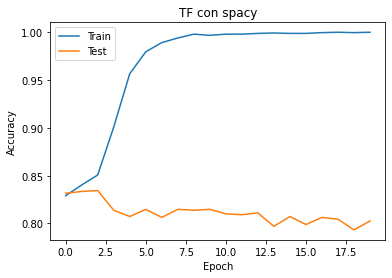

In [249]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con spacy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('img/accuracy'+SENTIMENT_NAME+'.png')
plt.show()


# Probamos con algunas inferencias

In [250]:
twt = 'Ya comienza a darme hambre; esa es buena señal'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='post', value=0)
sentiment = model.predict(twt,batch_size=1,verbose = 2)
if(np.round(sentiment) == 0):
    print("Desconocido")
elif (np.round(sentiment) == 1):
    print(SENTIMENT_NAME)

1/1 - 0s - 71ms/epoch - 71ms/step
Desconocido


2022-07-09 22:52:49.242036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [251]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

67/67 - 0s - loss: 1.2013 - accuracy: 0.8026 - 197ms/epoch - 3ms/step
score: 1.20
acc: 0.80


In [252]:
X_test.shape

(1069, 33)

In [253]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report
print(classification_report(Y_test, prediccion, target_names=['N','S']))

1069/1069 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           N       0.85      0.92      0.89       889
           S       0.35      0.20      0.25       180

    accuracy                           0.80      1069
   macro avg       0.60      0.56      0.57      1069
weighted avg       0.77      0.80      0.78      1069



# Guardamos el Modelo

In [254]:
file_path = "models/"+SENTIMENT_NAME+".jlb"
joblib.dump(model, file_path)

INFO:tensorflow:Assets written to: ram://f3c7b554-93c6-474d-8156-ffbc29d8ce3f/assets


INFO:tensorflow:Assets written to: ram://f3c7b554-93c6-474d-8156-ffbc29d8ce3f/assets


['models/pessimism.jlb']

# Predicciones en Dataset de Test

In [255]:
df_eval = pd.read_csv('data/sem_eval_test_blank_es.csv')
df_eval

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contra Myweather
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había llegado y me estaba llamando para decirme que el vuelo todavía no había salido 👍
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondizzoni.... #ironía jajajjajaja #unañomas
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años en prision 😃"
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de una mansa ni que terrible PLR
...,...,...
674,2018-Es-06551,@tccharless -Peligro al volante -Tec -Los Santos -Memes -Galletas -3C
675,2018-Es-02782,Vamos a ver q sucedio en mi barrio en los 90 #veronicalapelicula #Vallekas
676,2018-Es-01308,@kopexinfinity FELICIDADES FER 💕 QUE ESTA PASANDO AL AGUS PARA DARLE LIKE A FOTOS DE CARO JAJAAAA
677,2018-Es-02136,"@PabloEmanuel299 LAMENTO MI CONFUSIÓN DE RAMA LEGISLATIVA : Habida cuenta, publicamente corregí. Espero haber satisfecho el reclamo."


In [256]:
#Limpiando los datos 
df_eval.Tweet=df_eval.Tweet.apply(clean_text, lemas=True)
df_eval = df_eval[df_eval['Tweet']!='']
df_eval

,ID,Tweet
0,2018-Es-06697,no yo pensar perder el pelea de mcgregor contra myweather
1,2018-Es-05385,yo preocupado pensar que mi papá ya haber llegar y yo estar llamar para decir yo que el vuelo todavía no haber salir 👍
2,2018-Es-03777,pucha ya no yo servir todo el carro a rondizzoni ironía jajajjajaja unañomas
3,2018-Es-02175,si estar contigo ser uno delito hacer cien año en prision 😃
4,2018-Es-00726,perfect y de uno mansa ni que terrible plr
...,...,...
674,2018-Es-06551,peligro al volante tec los santos memes galleta 3c
675,2018-Es-02782,ir a ver q suceder en mi barrio en el 90 veronicalapelicula vallekas
676,2018-Es-01308,felicidades fer 💕 que este pasando al agus para darle like a foto de caro jajaaaa
677,2018-Es-02136,lamento mi confusión de rama legislativa habida cuenta publicamente corregí esperar haber satisfacer el reclamo


In [257]:
X_test_eval = tokenizer.texts_to_sequences(df_eval.Tweet)
X_test_eval = pad_sequences(X_test_eval, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [258]:
X_test_eval

array([[   9,    5,   83, ...,    0,    0,    0],
       [   5,  193,   83, ...,    0,    0,    0],
       [  28,    9,    5, ...,    0,    0,    0],
       ...,
       [ 249,    2,   19, ...,    0,    0,    0],
       [  13,    3,  158, ...,    0,    0,    0],
       [  13, 1846,   24, ...,    0,    0,    0]], dtype=int32)

In [259]:
X_test_eval.shape

(679, 33)

In [260]:
predict_eval = model.predict(X_test_eval, batch_size=1)

679/679 [==============================] - 1s 1ms/step


In [261]:
df_output = pd.DataFrame(df_eval.ID)
df_output[SENTIMENT_NAME] = predict_eval
df_output.to_csv('predictions/pred_'+SENTIMENT_NAME+'.csv', index = False)
df_output


,ID,pessimism
0,2018-Es-06697,5.870463e-01
1,2018-Es-05385,9.996414e-01
2,2018-Es-03777,1.611625e-03
3,2018-Es-02175,6.827750e-06
4,2018-Es-00726,1.248012e-01
...,...,...
674,2018-Es-06551,4.719444e-05
675,2018-Es-02782,1.158011e-03
676,2018-Es-01308,4.500119e-02
677,2018-Es-02136,4.746576e-04
